In [1]:
import sys,os,glob
import numpy as np
import ROOT
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

Welcome to JupyROOT 6.20/06


In [2]:
ROOT.gSystem.Load(os.path.abspath("../Delphes/libDelphes.so"))

0

In [3]:
try:
    ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

### Load ATLAS vertex reconstruction efficiencies:

In [4]:
interpDict = {}
for f in glob.glob('./HEPData-ins1630632-v2-csv/*csv'):
    with open(f,'r') as ff:
        data = []
        lines = ff.readlines()
        nheader = len([l for l in lines if (l.strip() and l.strip()[0] == '#')])
        description = [l for l in lines if 'description' in l][0]
        if not 'Parameterized vertex level efficiencies' in description:
            continue
        Rrange = description.split(' for truth decays with')[1].split('.')[0]
        Rmin = eval(Rrange.split()[0].replace('$',''))
        Rmax = eval(Rrange.split()[-2].replace('$',''))
        pts = np.genfromtxt(f,delimiter=',',comments='#',names=True,skip_header=nheader)
        for pt in pts:
            mDV = pt['m_Truth_vertex_GeV_LOW']
            nTracks = pt['Number_of_tracks_Truth_vertex_LOW']
            eff = pt['Vertex_selection_efficiency']
            data.append([mDV,nTracks,eff])
        data = np.array(data)
        interpDict[(Rmin,Rmax)] = LinearNDInterpolator(data[:,0:2],data[:,-1],
                                            fill_value=0.0)

### Load ATLAS benchmark results

In [5]:
f = './HEPData-ins1630632-v2-csv/Table1.csv'
ptsNoLRT = np.genfromtxt(f,delimiter=',',comments='#',names=True,skip_footer=61,skip_header=10)
ptsLRT = np.genfromtxt(f,delimiter=',',comments='#',names=True,skip_header=73)
print(ptsLRT.dtype.names)

('DV_radius_mm', 'Vertex_reconstruction_efficiency_with_LRT', 'error_', 'error__1')


### Define DisplacedVertex class

In [6]:
class DisplacedVertex(object):
    
    def __init__(self):
        self.tracks = []
        self.R = 0.0
        
    def computeRDV(self):
        RDV = np.mean([np.sqrt(track.X**2 + track.Y**2 + track.Z**2)
        
                       for track in self.tracks])
        return RDV
        
    def distanceTo(self,track):
        
        d = np.abs(self.R-np.sqrt(track.X**2 + track.Y**2 + track.Z**2))
        
        return d
    
    def addTrack(self,track):
        self.tracks.append(track)
        self.R = self.computeRDV()
        
    def getMass(self):
        pX = np.array([track.PT*np.cos(track.Phi) for track in self.tracks])
        pY = np.array([track.PT*np.sin(track.Phi) for track in self.tracks])
        pZ = np.array([track.PT*np.sinh(track.Eta) for track in self.tracks])
        #Track energy assuming pion mass:
        E = np.sqrt(pX**2 + pY**2 + pZ**2 + 0.139**2)
        
        #Compute total invariant mass:
        mDV = np.sqrt(E.sum()**2 - pX.sum()**2 - pY.sum()**2 - pZ.sum()**2)
        
        return mDV
        
    def getNTracks(self):
        
        return len(self.tracks)
        

In [7]:
inputFile = '../data/gluino_1200_lsp_100_tau_1.root'

# Create chain of root trees
chain = ROOT.TChain("Delphes")
chain.Add(inputFile)

# Create object of class ExRootTreeReader
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

In [8]:
# Get pointers to branches used in this analysis
tracks = treeReader.UseBranch("Track")
particles = treeReader.UseBranch("Particle")

In [9]:
# %% Loop over all events
effList = []
for entry in range(0, numberOfEntries):
    # Load selected branches with data from specified event
    treeReader.ReadEntry(entry)

    #Get DVs
    DVs = []
    for itrack in range(0,tracks.GetEntries()):
        track = tracks.At(itrack)
        #Apply basic selection:
        if track.PT < 1.0: continue
        if abs(track.D0) < 2.0: continue
        Rtrack = np.sqrt(track.X**2 + track.Y**2 + track.Z**2)
        matches = False        
        for DV in DVs:
            if DV.distanceTo(track) < 1.0:
                DV.addTrack(track)
                matches = True
        if not matches:
            newDV = DisplacedVertex()
            newDV.addTrack(track)
            DVs.append(newDV)
    
    #Compute reconstruction efficiency:
    for DV in DVs:
        mDV = DV.getMass()
        RDV = DV.R
        ntracks = DV.getNTracks()
        if mDV < 10: continue
        if ntracks < 5: continue
        if RDV > 300: continue
        ntracks = min(ntracks,45) #Assume the efficiency is flat for more than 45 tracks
        
        eff = 0.0
        for Rmin,Rmax in interpDict.keys():
            if Rmin <= RDV < Rmax:
                eff = interpDict[(Rmin,Rmax)]([mDV,ntracks])[0]
                break
        effList.append([RDV,eff])
#         print(mDV,RDV,ntracks,eff)


In [10]:
effList = np.array(effList)

In [11]:
print(effList.shape)

(67769, 2)


In [12]:
bins = np.arange(2.5,300.0,5.0)
effHist = np.histogram(effList[:,0],weights=effList[:,1],bins=bins)[0]
hist = np.histogram(effList[:,0],bins=bins)[0]
effHistAvg = effHist/hist

In [13]:
effHistAvg.shape,bins.shape

((59,), (60,))

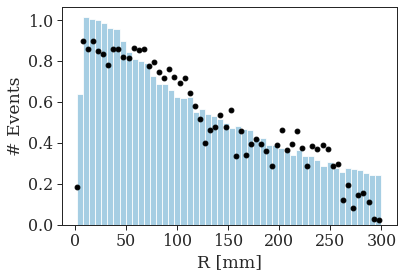

In [14]:
plt.hist(effList[:,0],bins=50,weights=[1./2500.]*len(effList))
plt.plot(ptsLRT['DV_radius_mm'],ptsLRT['Vertex_reconstruction_efficiency_with_LRT'],'o',c='black',
         label='ATLAS (with LRT)')
plt.xlabel('R [mm]')
plt.ylabel('# Events')
plt.savefig('RDV_delphes.png')
plt.show()

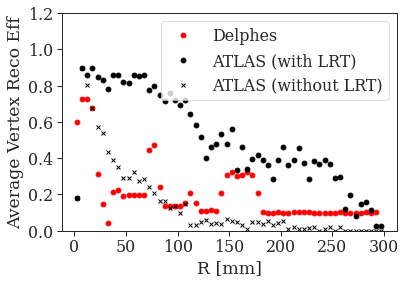

In [15]:
plt.plot(bins[:-1],effHistAvg,'o',c='red',label='Delphes')
plt.plot(ptsLRT['DV_radius_mm'],ptsLRT['Vertex_reconstruction_efficiency_with_LRT'],'o',c='black',
         label='ATLAS (with LRT)')
plt.plot(ptsNoLRT['DV_radius_mm'],ptsNoLRT['Vertex_reconstruction_efficiency_without_LRT'],'x',c='black',
         label='ATLAS (without LRT)')
plt.xlabel('R [mm]')
plt.ylabel('Average Vertex Reco Eff')
plt.ylim(0,1.2)
plt.legend()
plt.savefig('RDVeff_delphes.png')
plt.show()